<a href="https://colab.research.google.com/github/SergheiMihailov/ml-project-cassava/blob/main/evaluation_stacked_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U livelossplot
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 9.6MB/s 


In [3]:
# Imports
import gdown
import os
import json
import csv   
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import scipy.misc
import sklearn
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow.keras.layers.experimental.preprocessing as keras_preproc
import kerastuner as kt
import keras
import io
import json
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
import itertools
import numpy as np
import os, shutil
from datetime import datetime
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from collections import Counter
import random
from keras.models import model_from_json
from livelossplot import PlotLossesKeras
from keras.callbacks import CSVLogger

In [4]:
EVALUATION_IMAGES_PATH = 'evaluation_train_images/'
EVALUATION_LABELS_PATH = 'evaluation_train_data.csv'
TEST_IMAGES_PATH = 'test_images/'
TEST_LABELS_PATH = 'test_data.csv'

LABEL_TO_DISEASE_MAP_PATH = 'label_num_to_disease_map.json'
CONFUSION_MATRICES_PATH = '/content/drive/MyDrive/ml_project/stacked_confusion_matrices_v2/'
MODEL_CP_PATH = '/content/drive/MyDrive/ml_project/stacked_models_v2/'
HYPERPARAMETERS_PATH = '/content/drive/MyDrive/ml_project/hyperparams_stacked_v2'
LOGS_PATH = '/content/drive/MyDrive/ml_project/stacked_logs_v2'

N_CLASSES = 5

# Images
IMG_SIZE = 224
SIZE = (IMG_SIZE,IMG_SIZE)
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Training
EPOCHS_TO_TRAIN = 30
BATCH_SIZE = 32

In [5]:
os.chdir('/content/')

if not os.path.exists(LABEL_TO_DISEASE_MAP_PATH):
  !wget files.brainfriz.com/ml_project/label_num_to_disease_map.json

# if not os.path.exists(EVALUATION_IMAGES_PATH):
  !wget files.brainfriz.com/ml_project/evaluation_data.rar
  
if not os.path.exists('/content/drive/MyDrive/ml_project/'):
  !mkdir /content/drive/MyDrive/ml_project
  
if not os.path.exists(CONFUSION_MATRICES_PATH):
  !mkdir /content/drive/MyDrive/ml_project/stacked_confusion_matrices_v2 #for the confusion matrix images

if not os.path.exists(MODEL_CP_PATH):
  !mkdir /content/drive/MyDrive/ml_project/stacked_models_v2 # for saved models

--2021-03-26 13:25:37--  http://files.brainfriz.com/ml_project/label_num_to_disease_map.json
Resolving files.brainfriz.com (files.brainfriz.com)... 138.201.201.196
Connecting to files.brainfriz.com (files.brainfriz.com)|138.201.201.196|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.brainfriz.com/ml_project/label_num_to_disease_map.json [following]
--2021-03-26 13:25:37--  https://files.brainfriz.com/ml_project/label_num_to_disease_map.json
Connecting to files.brainfriz.com (files.brainfriz.com)|138.201.201.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172 [application/json]
Saving to: ‘label_num_to_disease_map.json’

label_num_to_diseas 100%[===================>]     172  --.-KB/s    in 0s      

2021-03-26 13:25:38 (34.9 MB/s) - ‘label_num_to_disease_map.json’ saved [172/172]

--2021-03-26 13:25:38--  http://files.brainfriz.com/ml_project/evaluation_data.rar
Resolving files.brainfriz.com (files.br

In [6]:
! unrar x evaluation_data.rar > /dev/null

In [7]:
# Dataset
train_data = pd.read_csv(EVALUATION_LABELS_PATH)
test_data = pd.read_csv(TEST_LABELS_PATH)

f = open(LABEL_TO_DISEASE_MAP_PATH)
label_class_name = json.load(f)
label_class_name = {int(k):v for k,v in label_class_name.items()}

train_data['class_name'] = train_data.label.map(label_class_name)
test_data['class_name'] = test_data.label.map(label_class_name)

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_dataframe(train_data,
                                directory = EVALUATION_IMAGES_PATH,
                                x_col = 'image_id',
                                y_col = 'class_name',
                                color_mode='rgb',
                                class_mode='categorical',
                                target_size = SIZE,
                                shuffle = True,
                                batch_size = BATCH_SIZE)

test_gen = test_datagen.flow_from_dataframe(test_data,
                                directory = TEST_IMAGES_PATH,
                                x_col = 'image_id',
                                y_col = 'class_name',
                                color_mode='rgb',
                                class_mode='categorical',
                                target_size = SIZE,
                                shuffle = False,
                                batch_size = BATCH_SIZE)

Found 64790 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames belonging to 5 classes.


In [8]:
# Evaluation definitions 

CONFUSION_MAT_EVERY_X_EPOCHS = 5

class ConfusionMatrix(keras.callbacks.Callback):
  def __init__(self, val_set, val_y):
    self.val_set = val_set
    self.val_y = val_y
    self.counter = 0

  def on_epoch_end(self, epoch, logs=None):
    if epoch % CONFUSION_MAT_EVERY_X_EPOCHS == 0 and epoch != 0:
      self.plot()
      self.counter += 1

  def plot(self):
    test_pred_raw = self.model.predict(self.val_set)
    test_pred = np.argmax(test_pred_raw, axis=1)

    cm = sklearn.metrics.confusion_matrix(self.val_y, test_pred)
    self.plot_confusion_matrix(cm, class_names=[0,1,2,3,4])

  def plot_confusion_matrix(self, cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      color = "white" if cm[i, j] > threshold else "black"
      plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(CONFUSION_MATRICES_PATH + 'conf{0}.png'.format(self.counter)) #save file
    plt.close()

In [15]:
# Models definition

def getEfficientNetB0():
  return [
      # architecture
      tf.keras.applications.EfficientNetB0(
        include_top=True, weights=None, input_tensor=None,
        input_shape=INPUT_SHAPE, pooling=None, classes=N_CLASSES,
        classifier_activation='softmax', drop_connect_rate=0.4
      ),
      # preprocess_input
      tf.keras.applications.efficientnet.preprocess_input
  ]

def getResNet50(): 
  return [
      # architecture 
      tf.keras.applications.ResNet50(
        include_top=True, weights=None, input_tensor=None,
        input_shape=INPUT_SHAPE, pooling='avg', classes=N_CLASSES,
        classifier_activation='softmax'
      ),
      # preprocess_input
      tf.keras.applications.resnet_v2.preprocess_input
  ]

def getMobileNetV3Small(): 
  return [
      # architecture
      tf.keras.applications.MobileNetV3Small(
        input_shape=INPUT_SHAPE, alpha=1, minimalistic=True, include_top=True,
        weights=None, input_tensor=None, classes=5, pooling=None,
        dropout_rate=0, classifier_activation='softmax'
      ),
      # preprocess_input:
      tf.keras.applications.mobilenet_v3.preprocess_input
  ]


def getDenseNet169(): 
  return [
      # architecture
      tf.keras.applications.DenseNet169(
          include_top=True, weights=None, input_tensor=None,
          input_shape=None, pooling=None, classes=5
      ),
      # preprocess_input:
      tf.keras.applications.densenet.preprocess_input
  ]


from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
def stacked_model_builder(hp):
  hp_learning_rate = hp.Float('learning_rate', 1e-05, 1, sampling='log')
  hp_label_smoothing = hp.Float('label_smoothing', 1e-09, 1e-02, sampling='log')


  hp_arch_drop_connect_rate = hp.Float('hp_arch_drop_connect_rate', 0.1, 0.9, step=0.1)
  hp_first_layers_excluded = hp.Int('hp_first_layers_excluded', 0, 1000, default=10)
  hp_dense_layer_1_units = hp.Int('hp_dense_layer_1_units', 64, 1024, default=256, step=64)
  hp_dense_layer_dropout = hp.Float('hp_dense_layer_dropout', 0.1, 0.9, default=0.5, step=0.1)
  hp_num_dense_layers = hp.Int('hp_num_dense_layers', 1, 5, default=2)

  model = Sequential()
  # initialize the model with input shape
  model.add(tf.keras.applications.EfficientNetB0(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                           weights = 'imagenet',
                           drop_connect_rate=hp_arch_drop_connect_rate))
  for layer in model.layers[:hp_first_layers_excluded]:
     layer.trainable = False

  model.add(GlobalAveragePooling2D())
  model.add(Flatten())
  model.add(Dense(hp_dense_layer_1_units, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
  model.add(Dropout(hp_dense_layer_dropout))

  for i in range(1, hp_num_dense_layers):
    model.add(Dense(hp_dense_layer_1_units / 2**i, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))) # half the number of units from previous dense layer
    model.add(Dropout(hp_dense_layer_dropout))

  model.add(Dense(N_CLASSES, activation = 'softmax'))  
    
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate, epsilon=0.1),
                loss=keras.losses.CategoricalCrossentropy(label_smoothing=hp_label_smoothing),
                metrics=['accuracy'])
    
  return model


def model_builder():  
  inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
  architecture, preprocess_input = getDenseNet169() # change architecture here
  # input_layer = preprocess_input(tf.keras.layers.Input(shape=INPUT_SHAPE)) #only for mobilenet change inputs to input_layer
  model = tf.keras.Model(inputs, architecture(inputs))
  
  hp_learning_rate = 0.02292 # your value
  hp_label_smoothing = 0.0052412 # your value
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate, epsilon=0.1),
                loss=keras.losses.CategoricalCrossentropy(label_smoothing=hp_label_smoothing),
                metrics=['accuracy'])


  return model

In [21]:


if os.path.exists(MODEL_CP_PATH+'saved_model.pb'): # loads saved model in case of a disconnection
  model = tf.keras.models.load_model(MODEL_CP_PATH)
else:
  model = model_builder()

tuner = kt.Hyperband(stacked_model_builder,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='/content/drive/MyDrive/ml_project/hyperparams_stacked_eff_net_b0_v2',
                     project_name='cassava'
                     )

train_set, val_set = getDatasetsForCrossValidationSplit(n_splits=N_CV_SPLITS ,split_index=0, shuffle=True, split_size=3000)

# Tune hyperparameters on first cross-validation (refactor later to use saved hps)
tuner.search(train_set, epochs=EPOCHS_TO_TRAIN, validation_data=val_set,callbacks=tuning_callbacks)

Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps)
model = tuner.hypermodel.build()

model = stacked_model_builder(None)

conf_matrix_plotter = ConfusionMatrix(test_gen, test_gen.classes);
live_loss_plotter = PlotLossesKeras()
csv_logger = tf.keras.callbacks.CSVLogger(MODEL_CP_PATH+"model_history_log.csv", separator=",", append=True)

training_callbacks = [
  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=3, min_lr=0.0001),
  tf.keras.callbacks.ModelCheckpoint(
      MODEL_CP_PATH, monitor='val_loss', verbose=0, save_best_only=False,
      save_weights_only=False, mode='auto', save_freq='epoch',
      options=None
  ),
  csv_logger,
  conf_matrix_plotter, # Confusion matrix
  live_loss_plotter,   # Accuracy and loss graphs
  tf.keras.callbacks.TensorBoard(
    log_dir=LOGS_PATH, histogram_freq=1, write_graph=True,
    write_images=False, update_freq='epoch', profile_batch=2,
    embeddings_freq=0, embeddings_metadata=None
  )
]

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 4,214,184
Trainable params: 4,172,161
Non-trainable params: 42,023
_______________________________________

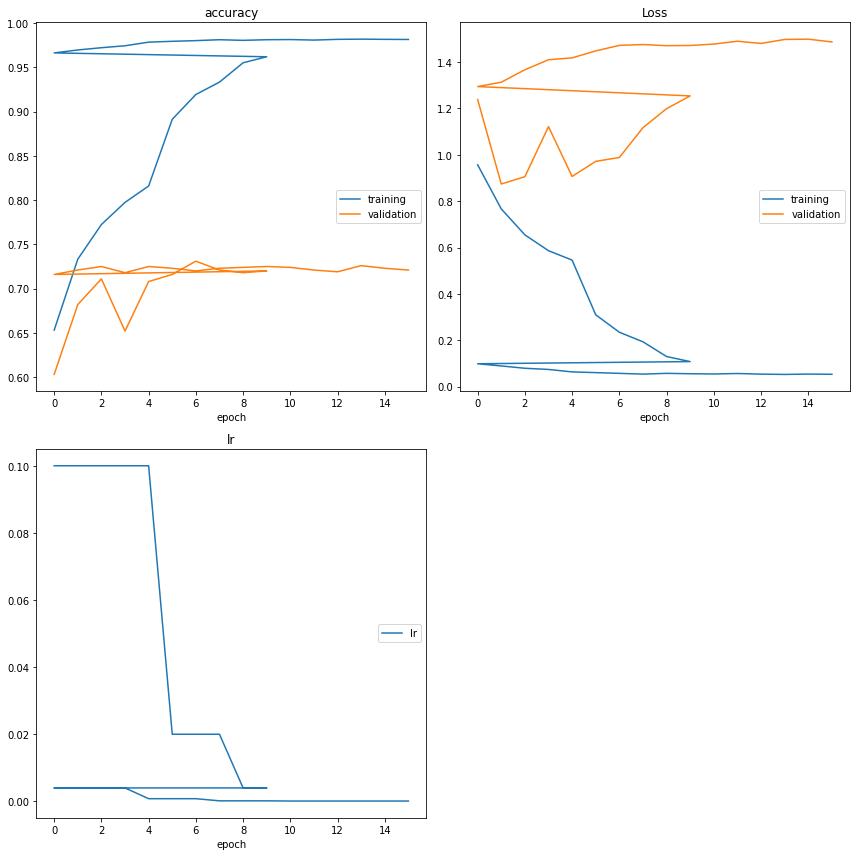

accuracy
	training         	 (min:    0.653, max:    0.982, cur:    0.982)
	validation       	 (min:    0.603, max:    0.731, cur:    0.721)
Loss
	training         	 (min:    0.052, max:    0.957, cur:    0.053)
	validation       	 (min:    0.874, max:    1.499, cur:    1.487)
lr
	lr               	 (min:    0.000, max:    0.100, cur:    0.000)
Epoch 17/30
1716/2024 [========================>.....] - ETA: 1:37 - loss: 0.0541 - accuracy: 0.9814

KeyboardInterrupt: ignored

In [23]:
history = model.fit(train_gen,
                    steps_per_epoch=train_gen.n // BATCH_SIZE,
                    validation_data=test_gen,
                    epochs=EPOCHS_TO_TRAIN,
                    callbacks = training_callbacks)

In [ ]:
model_json = model.to_json()
with open(MODEL_CP_PATH+"evaluation_model.json", "w") as json_file:
  json_file.write(model_json)

model.save_weights(MODEL_CP_PATH+"evaluation_model.h5")

NameError: ignored